# Moving Forward: Generating Our Own Dataset

## Mistakes were made

The available dataset was a disastrous failure. There are multiple reasons why using a ready dataset was not good for our task:
1. **Cleanliness:** The audio provided by datasets is way too perfect and clean. It does not match the prediction data at all, where the prediction data could be the full track, or a source-separated drum-track courtesy of another neural net. I am planning on using demucs v4, which yields the best results for separation quality currently.
2. **Class imbalance:** The dataset had a *horrendous* imbalance coefficient of 49 (meaning that there were 49 times as many snare drums as there were crash cymbals) $$Imbalance\ Coefficient = \frac{N_{\text{majority}}}{N_{\text{minority}}} =\frac{N_{\text{snare}}}{N_{\text{crash}}}=\frac{125049}{2552}\approx 49.01$$
3. **MIDI mismatch:** After listening to some stitched audio recordings of crash cymbals I acquired after processing the dataset, I have noticed that some onsets that were given by the MIDI were incredibly wrong. After setting a cutoff value of `50` for velocity, it helped with weeding out "ghost" crash cymbals that were very quiet, but reduced the duration of **ALL** available crash cymbals to a mere 7 seconds. It led me to also notice that the velocity value does not accurately represent the volume in the waveform, meaning that there could be loud crashes with a low velocity. Thus, there is an irreperable difference between the .wav and .midi files, which I assumed to be perfectly in line with one another.

All of this leads to one solution which I dreaded of even thinking about: **labeling my own dataset.** As scary as it sounds, it might not be as bad as you think. Here is the general outline I will follow to generate my own drumming dataset:
1. Select an audio source separating algorithm.
2. Install CUDA compatible with the latest PyTorch (currently it is CUDA 11.7)
3. Gather several fully instrumented audio files representative of different genres, tempos and styles.
4. Separate the drum tracks from the audio files and save them for the future dataset.
5. Record all drum track *file paths* in a `master.csv` file to be accessed later.
6. Accessing the .csv, use an onset detection algorithm to find instances of drum notes in each the drum tracks. I will be using the `librosa` package for this task.
7. Save the onsets as a .csv and register their name in the `master.csv` file.
8. Concatenate the entire list of onsets and verify if you have enough to label.
9. Start the labeling process by using the `pigeon` package to quickly and iteratively go through every onset and give them all a label.

I was able to get this idea of labeling my own data from Medium user [YoshiMan](https://yoshi-man.medium.com), who did a similar task a month ago and published their results in TowardsAI.

* It took them 5 hours to manually label **4,513** drum notes, which equates to roughly 900 labels per hour.
* The small dataset I used had **400,000** drum notes, and it was **6GB** of audio in size. 
* The large dataset I intended to use is **130GB** in size and has a colossal drum count of **13.1 million**.

In the case of MIR (music information retrieval) tasks, the nature of the prediction data is vastly different from the audio provided by ready datasets. Thus, it is imperative to use training data that closely resembles the prediction data. In this case, using a drum track obtained through a source separation algorithm provides a much more accurate representation of the prediction data, ensuring that the trained model will perform well on real-world tasks. Although the quantity of data may suffer significantly, the quality of the data will be worth the sacrifice, as it ensures that the trained model will perform well on real-world tasks, providing a more robust and reliable solution for the given task.

## Making The Perfect Playlist for My Model

To ensure that my efforts to label my own dataset are not wasted, I need to choose various tracks spanning multiple genres, tempos and styles. There are several genres that come to my mind:

1. **Punk Rock.** One of the very first issues I came across using a ready-made dataset was that it was incredibly imbalanced. One of the least occurent classes was the Crash Cymbal, making up a measly `0.64%` of the dataset. Punk Rock has a lot of aggressive style that utilizes a variety of crashes that should remedy my issue.
2. **Power Metal.** A sort of evolution of the Punk Rock style, this can help us gather good data for the genre's infamously cheesy blastbeat-laden fills and choruses. This will be a good source for gathering kick drum data.
3. **Progressive Metal.** A genre I selected due to its complex time-signatures, drum patterns and tempo relations. On top of that, has a rather varied accompaniment that can help bring extra data augmentation into the mix.
4. **Rock and Country.** Very average genres in terms of drumming patterns, helps with the more traditional and predictable drumming.
5. **Hip-hop.** Known for its complex drum rhythms, this will be crucial for training the model to recognize more intricate drumming.

## Creating the Dataset

### Getting Drum Onsets

In [1]:
import subprocess as sp
import torch
import librosa
import os
from IPython.display import Audio, display, Image
from ipywidgets import widgets
import matplotlib.pyplot as plt
import csv
import pandas as pd

output_path = "separated\htdemucs"
dataset_name = "HeartsOnFireDS-v.1.0.4"
labels = ['kick', 'snare', 'hihat', 'tom', 'crash', 'ride', 'other']

This code searches for all mp3 files in the `dataset_name` folder and adds them to the dataset accordingly: splitting the drums, getting the onsets and saving csv data.

In [2]:
files = os.listdir(dataset_name)
mp3_files = [os.path.splitext(f)[0] for f in files if f.endswith('.mp3')]

def generate_onsets(folder_path):
    drum_path = os.path.join(folder_path, "drums.mp3")
    y, sr = librosa.load(drum_path, sr=44100)

    onset_env = librosa.onset.onset_strength(y=y, sr=sr, n_fft=1024)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)

    return onset_times

def estimate_tempo(folder_path):
    drum_path = os.path.join(folder_path, "drums.mp3")
    y, sr = librosa.load(drum_path, sr=44100)
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
    return tempo

for filename in mp3_files:
    folder_path = os.path.join(dataset_name, filename)
    src_path = os.path.join(dataset_name, filename+".mp3")

    #step 1: split
    command = ["demucs", "--mp3", "--mp3-bitrate", "320", "--two-stems=drums", src_path]
    if torch.cuda.is_available():
        print("Generating splits for \""+filename+"\" with GPU...")
        sp.run(command)

    #step 2: move everything
    dest_path = os.path.join(folder_path, "audio.mp3")
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    os.rename(src_path, dest_path)

    src_path = os.path.join("separated/htdemucs", filename, "drums.mp3")
    dest_path = os.path.join(dataset_name, filename, "drums.mp3")
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    os.rename(src_path, dest_path)

    src_path = os.path.join("separated/htdemucs", filename, "no_drums.mp3")
    dest_path = os.path.join(dataset_name, filename, "no_drums.mp3")
    os.rename(src_path, dest_path)
    demucs_path = os.path.join("separated/htdemucs", filename)

    if os.path.exists(demucs_path) and os.path.isdir(demucs_path) and not os.listdir(demucs_path):
        os.rmdir(demucs_path)
    print("Generating onsets...")

    #step 3: generate onsets
    onset_times = generate_onsets(folder_path)
    
    #step 4: save onsets
    csv_file = os.path.join(folder_path, "onsets.csv")
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["onset_time"]+labels)
        for onset_time in onset_times:
            writer.writerow([onset_time]+[False]*len(labels))
    print("Done!")


#step 5: update the master csv
audio_info = []

for root, dirs, files in os.walk(dataset_name):
    for dir in dirs:
        processed_folder = os.path.join(root, dir)
        print("Updating " + processed_folder)
        if os.path.isdir(processed_folder):
            audio_path = os.path.join(processed_folder, "audio.mp3")
            drums_path = os.path.join(processed_folder, "drums.mp3")
            no_drums_path = os.path.join(processed_folder, "no_drums.mp3")
            onsets_path = os.path.join(processed_folder, "onsets.csv")
            
            # Check if the master CSV file exists and read the estimated tempo if available
            master_csv_file = os.path.join(dataset_name, "master.csv")
            if os.path.isfile(master_csv_file):
                with open(master_csv_file, "r", newline='') as csvfile:
                    reader = csv.reader(csvfile)
                    next(reader)  # Skip header
                    for row in reader:
                        if row[0] == dir:
                            tempo = row[5]  # Retrieve estimated tempo from master CSV
                            break
                    else:
                        tempo = None  # Tempo not found in master CSV
            else:
                tempo = None  # Master CSV does not exist
            
            # If tempo is not available in master CSV, estimate it
            if tempo is None:
                tempo = estimate_tempo(processed_folder)
            
            audio_info.append((dir, audio_path, drums_path, no_drums_path, onsets_path, tempo))

# write the audio information to a CSV file
with open(os.path.join(dataset_name, "master.csv"), "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["name", "audio", "drums", "no_drums", "onsets", "tempo"])
    writer.writerows(audio_info)

Updating HeartsOnFireDS-v.1.0.4\Atsushi Kitajoh - I'll Face Myself (-Battle-)
Updating HeartsOnFireDS-v.1.0.4\Crystallion - Eternia
Updating HeartsOnFireDS-v.1.0.4\Devin Townsend - Call of the Void
Updating HeartsOnFireDS-v.1.0.4\Happy Ol' McWeasel - Last Good Chance
Updating HeartsOnFireDS-v.1.0.4\Happy Ol'McWeasel - Heart on Fire
Updating HeartsOnFireDS-v.1.0.4\NanowaR of Steel - Disco Metal
Updating HeartsOnFireDS-v.1.0.4\Nathan Sharp - One Way Dream
Updating HeartsOnFireDS-v.1.0.4\Pantera - Walk
Updating HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin Townsend Remix)
Updating HeartsOnFireDS-v.1.0.4\Power Quest - Glorious
Updating HeartsOnFireDS-v.1.0.4\RENREN - Hungarian Rhapsody No. 2
Updating HeartsOnFireDS-v.1.0.4\Shoji Meguro - Long Way
Updating HeartsOnFireDS-v.1.0.4\Shoji Meguro - The Almighty
Updating HeartsOnFireDS-v.1.0.4\Toehider - I Have Little To No Memory of These Memories
Updating HeartsOnFireDS-v.1.0.4\Toehider - To Hide Her


### Reading the Dataset

And now we can read all info with pandas:

In [3]:
df = pd.read_csv(os.path.join(dataset_name, "master.csv"))
df

,name,audio,drums,no_drums,onsets,tempo
0,Atsushi Kitajoh - I'll Face Myself (-Battle-),HeartsOnFireDS-v.1.0.4\Atsushi Kitajoh - I'll ...,HeartsOnFireDS-v.1.0.4\Atsushi Kitajoh - I'll ...,HeartsOnFireDS-v.1.0.4\Atsushi Kitajoh - I'll ...,HeartsOnFireDS-v.1.0.4\Atsushi Kitajoh - I'll ...,101.332721
1,Crystallion - Eternia,HeartsOnFireDS-v.1.0.4\Crystallion - Eternia\a...,HeartsOnFireDS-v.1.0.4\Crystallion - Eternia\d...,HeartsOnFireDS-v.1.0.4\Crystallion - Eternia\n...,HeartsOnFireDS-v.1.0.4\Crystallion - Eternia\o...,172.265625
2,Devin Townsend - Call of the Void,HeartsOnFireDS-v.1.0.4\Devin Townsend - Call o...,HeartsOnFireDS-v.1.0.4\Devin Townsend - Call o...,HeartsOnFireDS-v.1.0.4\Devin Townsend - Call o...,HeartsOnFireDS-v.1.0.4\Devin Townsend - Call o...,92.285156
3,Happy Ol' McWeasel - Last Good Chance,HeartsOnFireDS-v.1.0.4\Happy Ol' McWeasel - La...,HeartsOnFireDS-v.1.0.4\Happy Ol' McWeasel - La...,HeartsOnFireDS-v.1.0.4\Happy Ol' McWeasel - La...,HeartsOnFireDS-v.1.0.4\Happy Ol' McWeasel - La...,90.666118
4,Happy Ol'McWeasel - Heart on Fire,HeartsOnFireDS-v.1.0.4\Happy Ol'McWeasel - Hea...,HeartsOnFireDS-v.1.0.4\Happy Ol'McWeasel - Hea...,HeartsOnFireDS-v.1.0.4\Happy Ol'McWeasel - Hea...,HeartsOnFireDS-v.1.0.4\Happy Ol'McWeasel - Hea...,92.285156
5,NanowaR of Steel - Disco Metal,HeartsOnFireDS-v.1.0.4\NanowaR of Steel - Disc...,HeartsOnFireDS-v.1.0.4\NanowaR of Steel - Disc...,HeartsOnFireDS-v.1.0.4\NanowaR of Steel - Disc...,HeartsOnFireDS-v.1.0.4\NanowaR of Steel - Disc...,151.999081
6,Nathan Sharp - One Way Dream,HeartsOnFireDS-v.1.0.4\Nathan Sharp - One Way ...,HeartsOnFireDS-v.1.0.4\Nathan Sharp - One Way ...,HeartsOnFireDS-v.1.0.4\Nathan Sharp - One Way ...,HeartsOnFireDS-v.1.0.4\Nathan Sharp - One Way ...,161.499023
7,Pantera - Walk,HeartsOnFireDS-v.1.0.4\Pantera - Walk\audio.mp3,HeartsOnFireDS-v.1.0.4\Pantera - Walk\drums.mp3,HeartsOnFireDS-v.1.0.4\Pantera - Walk\no_drums...,HeartsOnFireDS-v.1.0.4\Pantera - Walk\onsets.csv,120.185320
8,Pendulum - Crush (Devin Townsend Remix),HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin...,HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin...,HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin...,HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin...,87.592691
9,Power Quest - Glorious,HeartsOnFireDS-v.1.0.4\Power Quest - Glorious\...,HeartsOnFireDS-v.1.0.4\Power Quest - Glorious\...,HeartsOnFireDS-v.1.0.4\Power Quest - Glorious\...,HeartsOnFireDS-v.1.0.4\Power Quest - Glorious\...,107.666016


### Retrieve row for manual labeling

In [15]:
filtered_df = df[df['name'] == "Pendulum - Crush (Devin Townsend Remix)"]
selected_row = filtered_df.iloc[0]
selected_row

name                  Pendulum - Crush (Devin Townsend Remix)
audio       HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin...
drums       HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin...
no_drums    HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin...
onsets      HeartsOnFireDS-v.1.0.4\Pendulum - Crush (Devin...
tempo                                               87.592691
Name: 8, dtype: object

We can check an audio file for onsets:

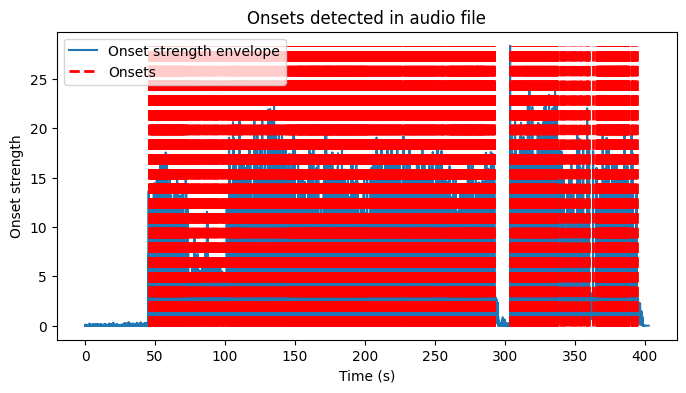

In [4]:
import numpy as np
from scipy import signal

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

y, sr = librosa.load(selected_row['drums'], sr=44100)

# y = y*5.0
onset_env = librosa.onset.onset_strength(y=y, sr=sr, n_fft=1024)
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
tempo, beats = librosa.beat.beat_track(y=y,sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(y))
clicks2 = librosa.clicks(frames=beats, sr=sr, length=len(y), click_freq=2000)

# Create a time vector
t = librosa.times_like(onset_env, sr=sr)

# Plot the onset strength envelope and onsets
plt.figure(figsize=(8, 4))
plt.plot(t, onset_env, label='Onset strength envelope')
plt.vlines(onset_times, 0, onset_env.max(), color='r', linestyle='--', linewidth=2.0, label='Onsets')
plt.xlabel('Time (s)')
plt.ylabel('Onset strength')
plt.title('Onsets detected in audio file')
plt.legend()
plt.show()

We can listen where `librosa` placed onsets by adding clicks to our audio files:

In [ ]:
display(Audio((y + clicks + clicks2), rate=sr))

## Labeling the Onsets

Now that we have a dataset with all onsets, we need to go through every single one and label them. 

We need to install `pigeonXT` for its **multi-label classification functionality**, as well as its Audio playback feature. We will load an audiofile and get snippets of it at the onset to classify that onset.

In [8]:
from pigeonXT import annotate
import re
import librosa.display
import numpy as np

onsets_df = pd.read_csv(selected_row['onsets'])
onsets_df = onsets_df.rename(columns={'onset_time': 'example'})
onsets_df['name'] = selected_row['name']

drum_file, sr = librosa.load(selected_row['drums'], sr=44100)
#display(Audio(drum_file, rate=sr, autoplay=False))

def display_fn(html):
    value = html.value
    match = re.search(r'\d+\.\d+', value)

    if match:
        number_str = match.group(0)
        onset_time = float(number_str)
    else:
        print('lol')
        return html

    start_sample = int(onset_time * sr)
    
    plt.close('all')
    mel = librosa.feature.melspectrogram(y=drum_file[start_sample-4096:start_sample+4096], sr=sr, n_fft=2048, hop_length=64, n_mels=128)
    meldb = librosa.power_to_db(mel, ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(meldb, x_axis='time',
                              y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    plt.show()
    
    end_sample = start_sample + sr//8
    end_sample2 = start_sample + 2*sr
    display(onset_time, Audio(drum_file[start_sample:end_sample], rate=sr, autoplay=True), Audio(drum_file[start_sample:end_sample2], rate=sr))

annotations = annotate(
    onsets_df,
    options=labels,
    task_type='multilabel-classification',
    display_fn=lambda filename: display_fn(filename)
)
#199

HTML(value='0 of 1005 Examples annotated, Current Position: 0 ')

Output()

**Save labeling progress by running cell below:**

In [9]:
output = annotations.rename(columns={'example': 'onset_time'})
#output = output.drop(["Unnamed: 0"], axis=1)
output.to_csv(selected_row['onsets'], index=False)
output

,onset_time,kick,snare,hihat,tom,crash,ride,other,name,changed
0,0.766259,True,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True
1,0.963628,False,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True
2,1.149388,False,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True
3,1.335147,True,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True
4,1.532517,False,True,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True
...,...,...,...,...,...,...,...,...,...,...
1000,283.608526,True,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),False
1001,283.771066,True,False,False,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),False
1002,283.945215,False,True,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),False
1003,284.119365,True,False,False,True,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),False


In [7]:
onsets_df = pd.concat([pd.read_csv(row) for row in df['onsets']])
counts = onsets_df.select_dtypes(include=bool).sum(axis=0)
counts

kick     3058
snare    2257
hihat    1969
tom       382
crash     535
ride      172
other     183
dtype: int64

### Splitting the dataset

Now we can split classes validation/training sets for training our model

In [4]:
for idx, row in df.iterrows():
    onsets_path = row['onsets']
    onsets_df = pd.read_csv(onsets_path)
    # Shuffle the dataframe
    onsets_df = onsets_df.sample(frac=1).reset_index(drop=True)
    
    # Assign 80% of onsets to training set, and 20% to validation set
    n = len(onsets_df)
    train_n = int(0.8 * n)
    onsets_df['split'] = 'training'
    onsets_df.loc[train_n:, 'split'] = 'validation'
    
    # Sort the dataframe by onset_time column
    onsets_df = onsets_df.sort_values(by='onset_time')
    
    # Write the updated onsets dataframe back to the CSV file
    onsets_df.to_csv(onsets_path, index=False)

## CSV to MIDI

In [16]:
import pretty_midi
from scipy.io.wavfile import write
import numpy as np
import fluidsynth

csv_to_midi = pd.read_csv(selected_row['onsets'])
midi = pretty_midi.PrettyMIDI(initial_tempo=selected_row['tempo'])

drum_program = 0  # MIDI program number for standard drum kit
drum_instrument = pretty_midi.Instrument(program=drum_program, is_drum=True)

# Iterate through the data rows
for index, row in csv_to_midi.iterrows():
    onset_time = row['onset_time']
    if row['kick']:
        kick_note = pretty_midi.Note(
            velocity=100,  # Set the velocity (volume) of the note
            pitch=36,  # Set the MIDI note number for kick drum
            start=onset_time,  # Set the start time of the note
            end=onset_time+0.1
        )
        drum_instrument.notes.append(kick_note)
    if row['snare']:
        snare_note = pretty_midi.Note(
            velocity=100,
            pitch=38,  # Set the MIDI note number for snare drum
            start=onset_time,
            end=onset_time+0.1
        )
        drum_instrument.notes.append(snare_note)
    if row['hihat']:
        hihat_note = pretty_midi.Note(
            velocity=100,
            pitch=42,  # Set the MIDI note number for hi-hat
            start=onset_time,
            end=onset_time+0.1
        )
        drum_instrument.notes.append(hihat_note)
    if row['tom']:
        tom_note = pretty_midi.Note(
            velocity=100,
            pitch=48,  # Set the MIDI note number for tom
            start=onset_time,
            end=onset_time+0.1
        )
        drum_instrument.notes.append(tom_note)
    if row['crash']:
        crash_note = pretty_midi.Note(
            velocity=100,
            pitch=49,  # Set the MIDI note number for crash cymbal
            start=onset_time,
            end=onset_time+0.1
        )
        drum_instrument.notes.append(crash_note)
    if row['ride']:
        ride_note = pretty_midi.Note(
            velocity=100,
            pitch=51,  # Set the MIDI note number for ride cymbal
            start=onset_time,
            end=onset_time+0.1
        )
        drum_instrument.notes.append(ride_note)
    if row['other']:
        other_note = pretty_midi.Note(
            velocity=100,
            pitch=60,  # Set the MIDI note number for other instrument
            start=onset_time,
            end=onset_time+0.1
        )
        drum_instrument.notes.append(other_note)
# Add the instrument objects to the MIDI object
midi.instruments.extend([drum_instrument])
# Save the MIDI file
synth = midi.fluidsynth(sf2_path='JV_1080_Drums.sf2')
output_file = f'{selected_row["name"]}.wav'
write(output_file, 44100, synth.astype(np.float32))